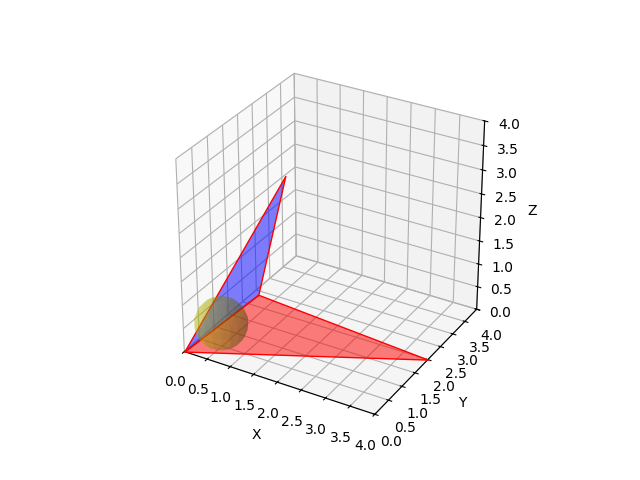

Dropdown(description='Number:', options=(('Select number of triangles', 0), ('1', 1), ('2', 2), ('3', 3), ('4'…

Button(description='Plot', style=ButtonStyle())

Button(description='Export Tris to STL', style=ButtonStyle())

Button(description='Export Sphere to data', style=ButtonStyle())

Exported triangles to triangles.stl
Exported sphere to sphere.lammps


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import ipywidgets as widgets
from IPython.display import display, clear_output
import stl
from stl import mesh
from ipywidgets import HBox, HTML, Layout
%matplotlib widget

# Function to parse input string into numpy array
def parse_input(input_str):
    coords = np.array([float(x) for x in input_str.split(',')])
    return coords.reshape((3, 3))

# Plotting function to include triangles and a sphere
def plot_figures(triangle_inputs, sphere_center_str='', sphere_radius=0):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    colors = ['blue', 'red', 'green', 'orange', 'purple']  # Colors for up to 5 triangles
    
    lo = 1e10
    hi = -1e10
    # Plot triangles using Poly3DCollection
    for i, triangle in enumerate(triangle_inputs):
        if triangle:  # Check if the input string is not empty
            t = parse_input(triangle)
            verts = [list(zip(t[:,0], t[:,1], t[:,2]))]
            if np.min(verts) < lo:
                lo = np.min(verts)
            if np.max(verts) > hi:
                hi = np.max(verts)
            poly = Poly3DCollection(verts, facecolors=colors[i % len(colors)], linewidths=1, edgecolors='r', alpha=0.5)
            ax.add_collection3d(poly)
    
    # Plot sphere
    if sphere_center_str and sphere_radius > 0:
        sphere_center = np.array([float(x) for x in sphere_center_str.split(',')])
        u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
        x = sphere_center[0] + sphere_radius * np.cos(u) * np.sin(v)
        y = sphere_center[1] + sphere_radius * np.sin(u) * np.sin(v)
        z = sphere_center[2] + sphere_radius * np.cos(v)

        if sphere_center.min()-sphere_radius < lo:
            lo = sphere_center.min()-sphere_radius
        if sphere_center.max()+sphere_radius > hi:
            hi = sphere_center.max()+sphere_radius
        ax.plot_surface(x, y, z, color='y', alpha=0.3)
    
    ax.set_xlim([lo, hi])
    ax.set_ylim([lo, hi])
    ax.set_zlim([lo, hi])
    ax.set_aspect('equal')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

# UI for selecting the number of triangles and inputting their vertices
def update_triangle_inputs(change):
    num_triangles = change.new
    triangle_widgets = []
    for i in range(num_triangles):
        triangle_label = HTML(f'<div style="width:300px;">Triangle {i+1} (x1,y1,z1, x2,y2,z2, x3,y3,z3):</div>')
        triangle_input = widgets.Text()
        triangle_widget = HBox([triangle_label, triangle_input])
        triangle_widgets.append(triangle_widget)
    triangles_input.children = triangle_widgets

num_triangles_selector = widgets.Dropdown(
    options=[('Select number of triangles', 0)] + [(f'{i}', i) for i in range(1, 6)],
    description='Number:',
)

triangles_input = widgets.VBox(children=[])
num_triangles_selector.observe(update_triangle_inputs, names='value')

# Sphere input widgets with HTML labels for full visibility
sphere_center_label = HTML('<div style="width:200px;">Sphere Center (x,y,z):</div>')
sphere_center_input = widgets.Text()
sphere_center_widget = HBox([sphere_center_label, sphere_center_input])

sphere_radius_label = HTML('<div style="width:200px;">Sphere Radius:</div>')
sphere_radius_input = widgets.FloatText()
sphere_radius_widget = HBox([sphere_radius_label, sphere_radius_input])

# Plot button
plot_button = widgets.Button(description="Plot")

# Export buttons
export_triangles_button = widgets.Button(description="Export Tris to STL")
export_sphere_button = widgets.Button(description="Export Sphere to data")

# Button click actions
def export_triangles_action(b):
    triangle_inputs = [hbox.children[1].value for hbox in triangles_input.children if hbox.children[1].value.strip() != '']
    export_triangles_to_stl(triangle_inputs)

def export_sphere_action(b):
    export_sphere_to_lammps(sphere_center_input.value, sphere_radius_input.value)

export_triangles_button.on_click(export_triangles_action)
export_sphere_button.on_click(export_sphere_action)

# Function to export triangles to STL
def export_triangles_to_stl(triangle_inputs):
    triangles = [parse_input(triangle) for triangle in triangle_inputs if triangle]
    # Create a new mesh
    tri_mesh = mesh.Mesh(np.zeros(len(triangles) * 2, dtype=mesh.Mesh.dtype))
    for i, t in enumerate(triangles):
        for j in range(2):  # Create two triangles for each input to form a rectangular patch
            tri_mesh.vectors[i * 2 + j] = [t[0], t[j+1], t[(j+2) % 3]]
    tri_mesh.save('triangles.stl', mode=stl.Mode.ASCII)
    print("Exported triangles to triangles.stl")

# Function to export sphere to a LAMMPS data file for atom_style sphere
def export_sphere_to_lammps(sphere_center_str, sphere_radius):
    sphere_center = [float(x) for x in sphere_center_str.split(',')]
    diameter = sphere_radius * 2
    density = 1.0  # Assuming a density of 1.0; adjust as necessary for your simulation
    
    with open('sphere.lammps', 'w') as lammps_file:
        lammps_file.write("LAMMPS data file for sphere\n\n")
        lammps_file.write("1 atoms\n\n")  # Number of atoms
        lammps_file.write("1 atom types\n\n")  # Number of atom types
        
        # Box bounds (assuming the sphere is centered and the box is slightly larger than the sphere)
        lammps_file.write(f"0.0 {sphere_center[0] + sphere_radius + 1.0} xlo xhi\n")
        lammps_file.write(f"0.0 {sphere_center[1] + sphere_radius + 1.0} ylo yhi\n")
        lammps_file.write(f"0.0 {sphere_center[2] + sphere_radius + 1.0} zlo zhi\n\n")
        
        lammps_file.write("Masses\n\n")
        lammps_file.write("1 1.0\n\n")  # Assuming mass of 1.0 for atom type 1; adjust as necessary
        
        lammps_file.write("Atoms\n\n")
        # Atom ID, Atom Type, x, y, z, diameter, density
        lammps_file.write(f"1 1 {sphere_center[0]} {sphere_center[1]} {sphere_center[2]} {diameter} {density}\n")
    
    print("Exported sphere to sphere.lammps")


def on_plot_button_clicked(b):
    clear_output(wait=True)
    triangle_inputs = [hbox.children[1].value for hbox in triangles_input.children if hbox.children[1].value.strip() != '']
    plot_figures(triangle_inputs, sphere_center_input.value, sphere_radius_input.value)
    # Redisplay all UI components, including the export buttons
    display(num_triangles_selector, triangles_input, sphere_center_widget, sphere_radius_widget, plot_button, export_triangles_button, export_sphere_button)

plot_button.on_click(on_plot_button_clicked)

# Display initial UI components
display(num_triangles_selector, triangles_input, sphere_center_widget, sphere_radius_widget, plot_button, export_triangles_button, export_sphere_button)